In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import shutil
import sys
import time
import pprint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.1
tensorflow 2.1.0
tensorflow_core.keras 2.2.4-tf


In [17]:
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


(20640, 8)
(20640,)


In [18]:
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [19]:
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [20]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [21]:
#函数式API 功能API
# input = keras.layers.Input(shape=x_train.shape[1:])
# hidden1 = keras.layers.Dense(30,activation='relu')(input)
# hidden11=keras.layers.BatchNormalization()(hidden1)   #批归一化

# hidden2 = keras.layers.Dense(30,activation='relu')(hidden11)
# hidden21=keras.layers.BatchNormalization()(hidden2)   #批归一化

# hidden3= keras.layers.Dense(30,activation='relu')(hidden21)
# hidden31=keras.layers.BatchNormalization()(hidden3)   #批归一化


# concat = keras.layers.concatenate([input, hidden31])
# output = keras.layers.Dense(1)(concat)
# model = keras.models.Model(inputs=[input],
#                           outputs=[output])

#子类API
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel,self).__init__()
        """定义函数层次"""
        self.hidden1_layer = keras.layers.Dense(30)                 #定义一个全联接层
        self.hidden11_layer=keras.layers.BatchNormalization()       #批归一化
        self.hidden12_layer = keras.layers.Activation('relu')       #激活函数
        self.hidden2_layer = keras.layers.Dense(30)
        self.hidden21_layer=keras.layers.BatchNormalization()
        self.hidden22_layer = keras.layers.Activation('relu')
        self.output_layer = keras.layers.Dense(1)
        
    def call(self,input):
        hidden1 = self.hidden1_layer(input)
        hidden11 = self.hidden11_layer(hidden1)
        hidden12 = self.hidden12_layer(hidden11)
        
        hidden2 = self.hidden2_layer(hidden12)
        hidden21 = self.hidden21_layer(hidden2)
        hidden22 = self.hidden22_layer(hidden21)
        concat = keras.layers.concatenate([input,hidden22])
        output = self.output_layer(hidden22)
        return output
#model = WideDeepModel()

model = keras.models.Sequential([
    WideDeepModel(),
])
model.build(input_shape=(None,8))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide_deep_model_2 (WideDeepM multiple                  1471      
Total params: 1,471
Trainable params: 1,351
Non-trainable params: 120
_________________________________________________________________


In [29]:
model.compile(loss="mean_squared_error",optimizer="sgd")#,metrics=["accuracy"])

#重新建立文件夹
logdir = './wide_deep_subclass'
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.mkdir(logdir)    
output_model_file = os.path.join(logdir,
                                "house_price_model.h5")

#Tensorboard, earlystopping, ModelCheckpoint
callbacks = [
#    keras.callbacks.TensorBoard(logdir),
#    keras.callbacks.ModelCheckpoint(output_model_file,
#                                   save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2) #连续5次损失函数和上一次差距小于1e-3即可停止训练    
]
his = model.fit(x_train_scaled,y_train,
                epochs =100, 
         validation_data=(x_valid_scaled,y_valid),
                 callbacks = callbacks)  #epochs 训练次数
#终端命令 tensorboard --logdir=callbacks 

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.3702 - val_loss: 0.4172
Epoch 2/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3582 - val_loss: 0.4105
Epoch 3/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3622 - val_loss: 0.4075
Epoch 4/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3636 - val_loss: 0.4285
Epoch 5/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3592 - val_loss: 0.4685
Epoch 6/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3640 - val_loss: 0.4026
Epoch 7/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3579 - val_loss: 0.4195
Epoch 8/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3546 - val_loss: 0.4865
Epoch 9/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.354

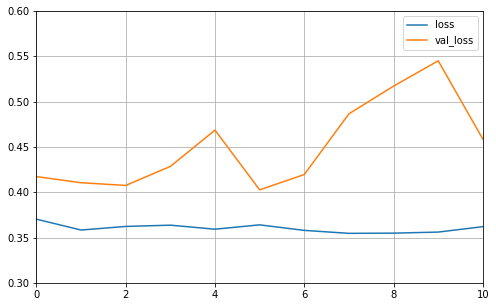

In [31]:
 def plot_learning_curves(his):
        pd.DataFrame(his.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0.3,0.6)
        plt.show()
        
plot_learning_curves(his)

In [32]:
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.4808


0.48077174231063485